# Notebook Preparation

In [ ]:
import os
import sys

try:
    ##################################################################################
    import google.colab
    print("Running on Google Colab. Mounting Google Drive...")

    from google.colab import drive, files
    drive.mount("/content/drive"
    , force_remount=True
    )

    main_directory_path = "./drive/My Drive/Group14/"
    data_path = main_directory_path + "Data/"
    output_path = data_path + "Output/"
    plot_path = output_path + "Plots/"
    dataset_path = data_path + "Dataset/"
    features_path = data_path + "Features/"
    script_path = main_directory_path + 'Scripts/'
    sys.path.append(script_path)

    print("Gooogle Drive mounted!")
    ##################################################################################


    ##################################################################################
    print("Loading Functions...")

    import EDA_Functions
    import Feature_Extraction

    print("Functions are ready!")
    ##################################################################################

except ImportError:
    print("Running in a local environment.")

    # main_directory_path = "./drive/My Drive/Colab Notebooks/RDkit experimentation/"
    # script_path = main_directory_path + 'Scripts/'
    # data_path = main_directory_path + "Data/"
    # dataset_path = data_path + "Dataset/"
    # features_path = data_path + "Features/"

Running on Google Colab. Mounting Google Drive...
Mounted at /content/drive
Gooogle Drive mounted!
Loading Functions...
Functions are ready!


Install

In [ ]:
!pip install --upgrade -q rdkit py3Dmol #
# !pip install -q iterative-stratification scikit-multilearn
# !pip3 install -q setuptools wheel auto-sklearn
# !pip install --upgrade pip auto-sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.7 MB/s eta 0:00:00


In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict
# import skmultilearn
# from skmultilearn.model_selection import iterative_train_test_split
# from sklearn.model_selection import train_test_split
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

Imports

In [ ]:
# Standard libraries
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# RDKit library
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem, RDKFingerprint, MACCSkeys, rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps

# 3D modeling
import py3Dmol

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Local application/library specific imports
from EDA_Functions import sort_words, remove_duplicates, check_duplicates, save_figure
from EDA_Functions import check_graph_2d, display_molecule, check_graph_3d
from feature_extraction import add_selected_fingerprints, add_all_descriptors

# Feature Extraction

In [ ]:
dataset_ex = ["_binary_multi.csv"]
datasets = [f for f in os.listdir(dataset_path) if f.endswith(".csv") and f not in dataset_ex]
print(datasets)

['molecule_smiles.csv', 'molecule_smiles_processed.csv', 'molecule_with_canonical_smiles.csv', 'smiles_descriptors.csv', 'smiles_descriptors_processed_no_scale.csv', 'smiles_descriptors_processed_minmax.csv', 'smiles_descriptors_fingerprints_fused.csv', 'smiles_fingerprints.csv', 'molecule_smiles_binary_multi.csv', 'molecule_smiles_processed_binary_multi.csv', 'molecule_with_canonical_smiles_binary_multi.csv', 'smiles_descriptors_binary_multi.csv', 'smiles_descriptors_processed_no_scale_binary_multi.csv', 'smiles_descriptors_processed_minmax_binary_multi.csv', 'smiles_descriptors_fingerprints_fused_binary_multi.csv', 'smiles_fingerprints_binary_multi.csv']


In [ ]:
dataset = datasets[1]
dataset

In [ ]:
df = pd.read_csv(dataset_path + dataset)
# print(df.head())
# print("\nShape: ", df.shape)
df.info()

## Descriptors

Based on: https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

In [ ]:
df_descriptors = add_all_descriptors(df)
df_descriptors.columns
df_descriptors.to_csv(dataset_path+'smiles_descriptors.csv', index=False)

Missing Values

In [ ]:
df = df_descriptors.copy()
# Check if there are any NaN values in the dataset
nan_in_data = df.isnull().values.any()
print(f"Are there NaNs in the data? {nan_in_data}")

if nan_in_data:
    print("NaNs per column:")
    nans_per_column = df.isnull().sum()
    print(nans_per_column[nans_per_column > 0])

Are there NaNs in the data? True
NaNs per column:
MaxPartialCharge        2
MinPartialCharge        2
MaxAbsPartialCharge     2
MinAbsPartialCharge     2
BCUT2D_MWHI            12
BCUT2D_MWLOW           12
BCUT2D_CHGHI           12
BCUT2D_CHGLO           12
BCUT2D_LOGPHI          12
BCUT2D_LOGPLOW         12
BCUT2D_MRHI            12
BCUT2D_MRLOW           12
dtype: int64


Imputing the NaN using the Imputer of

In [ ]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
missing_values = df.isna()

numeric_cols = df.select_dtypes(include=[np.number])
non_numeric_cols = df.select_dtypes(exclude=[np.number])

imputed_data = imputer.fit_transform(numeric_cols)
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)
imputed_df = pd.concat([non_numeric_cols, imputed_df], axis=1)
imputed_df.isnull().values.any()
# imputed_df

False

Remove  columns with constant value to the all samples

In [ ]:
cleaned_df = imputed_df.loc[:, imputed_df.apply(pd.Series.nunique) != 1]

numeric_cols = cleaned_df.select_dtypes(include=[np.number])
non_numeric_cols = cleaned_df.select_dtypes(exclude=[np.number])
# cleaned_df

In [ ]:
cleaned_df.to_csv(dataset_path+'smiles_descriptors_processed_no_scale.csv', index=False)

In [ ]:
minmax_scaler = MinMaxScaler()
stndrdzd_scaler = StandardScaler()

minmax_scaled_data = minmax_scaler.fit_transform(numeric_cols)
stndrdzd_scaled_data = stndrdzd_scaler.fit_transform(numeric_cols)

minmax_df = pd.DataFrame(minmax_scaled_data, columns=numeric_cols.columns)
stndrdzd_df = pd.DataFrame(stndrdzd_scaled_data, columns=numeric_cols.columns)

minmax_df = pd.concat([non_numeric_cols, minmax_df], axis=1)
stndrdzd_df = pd.concat([non_numeric_cols, stndrdzd_df], axis=1)

minmax_df.info()
stndrdzd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Columns: 191 entries, SMILES to SPS.1
dtypes: float64(189), object(2)
memory usage: 6.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Columns: 191 entries, SMILES to SPS.1
dtypes: float64(189), object(2)
memory usage: 6.3+ MB


.iloc[:, :]

In [ ]:
data = minmax_df.iloc[:]
data

,SMILES,SENTENCE,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_term_acetylene,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,SPS.1
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose",0.791339,0.791339,0.069086,0.765848,0.522755,0.390503,0.132731,0.128146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390503
1,COC(=O)OC,"ethereal,fruity,fresh",0.658966,0.658966,0.328704,0.665792,0.434143,0.103993,0.048067,0.049807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103993
2,Cc1cc2c([nH]1)cccc2,"animalic,resinous",0.220539,0.220539,0.611111,0.902183,0.614179,0.155989,0.082107,0.083660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155989
3,C1CCCCCCCC(=O)CCCCCCC1,"musk,powdery,animalic",0.783479,0.783479,0.255599,0.812762,0.597906,0.347807,0.170923,0.160182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347807
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"fruity,coniferous,camphor",0.799792,0.799792,0.002512,0.747839,0.764012,0.575018,0.170886,0.163728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.575018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"citrus,floral",0.826837,0.826837,0.014421,0.744844,0.711534,0.696255,0.145982,0.142370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.696255
4312,CC1(O)C2(C)CCCC1(C)CC2,"watery,earthy",0.710160,0.710160,0.104167,0.695851,0.641426,0.876509,0.112835,0.106788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.876509
4313,C1CC(=N[C@@H]1C(=O)O)O,"ethereal,sweet",0.685553,0.685553,0.019722,0.627836,0.575734,0.382957,0.080398,0.083618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382957
4314,CCCc1c(C)ncc(C)n1,nut,0.297800,0.297800,0.506505,0.875872,0.702875,0.149911,0.097882,0.096113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149911


In [ ]:
data.to_csv(dataset_path+'smiles_descriptors_processed.csv', index=False)

## Fingerprints

In [ ]:
df_fingerprints = add_selected_fingerprints(df
                              #  ,rdkit_fp=True
                              #  ,atompair_fp=True
                              #  ,torsion_fp=True
                              #  ,maccs_fp=True
                               ,morgan_fp=True
                               )
df_fingerprints.to_csv(dataset_path+'smiles_morgan_fp.csv', index=False)

In [ ]:
df2 = df_fingerprints.iloc[:]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Columns: 2050 entries, SMILES to Morgan_FP_2047
dtypes: int64(2048), object(2)
memory usage: 67.5+ MB


## Fused FP and MinMaxDescriptors

In [ ]:
additional_columns = df2.columns.difference(data.columns)
fused = pd.concat([data, df2[additional_columns]], axis=1)

In [ ]:
fused

,SMILES,SENTENCE,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Morgan_FP_990,Morgan_FP_991,Morgan_FP_992,Morgan_FP_993,Morgan_FP_994,Morgan_FP_995,Morgan_FP_996,Morgan_FP_997,Morgan_FP_998,Morgan_FP_999
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose",0.791339,0.791339,0.069086,0.765848,0.522755,0.390503,0.132731,0.128146,...,0,0,0,0,0,0,0,0,0,0
1,COC(=O)OC,"ethereal,fruity,fresh",0.658966,0.658966,0.328704,0.665792,0.434143,0.103993,0.048067,0.049807,...,0,0,0,0,0,0,0,0,0,0
2,Cc1cc2c([nH]1)cccc2,"animalic,resinous",0.220539,0.220539,0.611111,0.902183,0.614179,0.155989,0.082107,0.083660,...,0,0,0,0,0,0,0,0,0,0
3,C1CCCCCCCC(=O)CCCCCCC1,"musk,powdery,animalic",0.783479,0.783479,0.255599,0.812762,0.597906,0.347807,0.170923,0.160182,...,0,0,0,0,0,0,0,0,0,0
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"fruity,coniferous,camphor",0.799792,0.799792,0.002512,0.747839,0.764012,0.575018,0.170886,0.163728,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"citrus,floral",0.826837,0.826837,0.014421,0.744844,0.711534,0.696255,0.145982,0.142370,...,0,0,0,0,0,0,0,0,0,0
4312,CC1(O)C2(C)CCCC1(C)CC2,"watery,earthy",0.710160,0.710160,0.104167,0.695851,0.641426,0.876509,0.112835,0.106788,...,0,0,0,0,0,0,0,0,0,0
4313,C1CC(=N[C@@H]1C(=O)O)O,"ethereal,sweet",0.685553,0.685553,0.019722,0.627836,0.575734,0.382957,0.080398,0.083618,...,0,0,0,0,0,0,0,0,0,0
4314,CCCc1c(C)ncc(C)n1,nut,0.297800,0.297800,0.506505,0.875872,0.702875,0.149911,0.097882,0.096113,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fused.to_csv(dataset_path+'smiles_descriptors_fingerprints.csv', index=False)

In [ ]:
fused = pd.merge(data, df2, on='SMILES')

In [ ]:
fused

,SMILES,SENTENCE_x,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,Morgan_FP_2038,Morgan_FP_2039,Morgan_FP_2040,Morgan_FP_2041,Morgan_FP_2042,Morgan_FP_2043,Morgan_FP_2044,Morgan_FP_2045,Morgan_FP_2046,Morgan_FP_2047
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose",0.791339,0.791339,0.069086,0.765848,0.522755,0.390503,0.132731,0.128146,...,0,0,0,0,0,0,0,0,0,0
1,COC(=O)OC,"ethereal,fruity,fresh",0.658966,0.658966,0.328704,0.665792,0.434143,0.103993,0.048067,0.049807,...,0,0,0,0,0,0,0,0,0,0
2,Cc1cc2c([nH]1)cccc2,"animalic,resinous",0.220539,0.220539,0.611111,0.902183,0.614179,0.155989,0.082107,0.083660,...,0,0,0,0,0,0,0,0,0,1
3,C1CCCCCCCC(=O)CCCCCCC1,"musk,powdery,animalic",0.783479,0.783479,0.255599,0.812762,0.597906,0.347807,0.170923,0.160182,...,0,0,0,0,0,0,0,0,0,0
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"fruity,coniferous,camphor",0.799792,0.799792,0.002512,0.747839,0.764012,0.575018,0.170886,0.163728,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"citrus,floral",0.826837,0.826837,0.014421,0.744844,0.711534,0.696255,0.145982,0.142370,...,0,0,0,0,0,0,0,0,0,1
4312,CC1(O)C2(C)CCCC1(C)CC2,"watery,earthy",0.710160,0.710160,0.104167,0.695851,0.641426,0.876509,0.112835,0.106788,...,0,0,0,0,0,0,0,0,0,0
4313,C1CC(=N[C@@H]1C(=O)O)O,"ethereal,sweet",0.685553,0.685553,0.019722,0.627836,0.575734,0.382957,0.080398,0.083618,...,0,0,0,0,0,0,0,0,0,0
4314,CCCc1c(C)ncc(C)n1,nut,0.297800,0.297800,0.506505,0.875872,0.702875,0.149911,0.097882,0.096113,...,0,0,0,0,0,0,0,0,0,0


## Add Binary and Multi labels in the datasets

In [ ]:
datasets

['molecule_smiles.csv',
 'molecule_smiles_processed.csv',
 'molecule_with_canonical_smiles.csv',
 'smiles_descriptors.csv',
 'smiles_descriptors_processed_no_scale.csv',
 'smiles_descriptors_processed_minmax.csv',
 'smiles_descriptors_fingerprints_fused.csv',
 'smiles_fingerprints.csv']

Add the multi and the binary labels

In [ ]:
enc = MultiLabelBinarizer()
for dataset in datasets:
    # Read the dataset
    data = pd.read_csv(dataset_path + dataset)


    # Create binary column for 'odorless'
    data['binary'] = data['SENTENCE'].apply(lambda x: 1 if 'odorless' in x else 0)

    # Split SENTENCE into a list of labels and transform
    data['target'] = data['SENTENCE'].apply(lambda x: x.split(','))
    multi_label_encoded = enc.fit_transform(data['target'])

    # Convert the encoded labels to a list of lists and store in 'multi' column
    data['multi'] = multi_label_encoded.tolist()

    # Drop the 'target' column as it's no longer needed
    data.drop('target', axis=1, inplace=True)

    # Get a list of all column names
    cols = data.columns.tolist()

    # Find the index of 'SENTENCE' column
    sentence_index = cols.index('SENTENCE')

    # Rearrange columns so 'binary' and 'multi' follow 'SENTENCE'
    new_order = cols[:sentence_index + 1] + ['binary', 'multi'] + cols[sentence_index + 1:-2]
    data = data[new_order]
    data.to_csv(dataset_path + dataset.replace('.csv', '_binary_multi.csv'), index=False)

    print(f"Processed {dataset}")

Processed molecule_smiles.csv
Processed molecule_smiles_processed.csv
Processed molecule_with_canonical_smiles.csv
Processed smiles_descriptors.csv
Processed smiles_descriptors_processed_no_scale.csv
Processed smiles_descriptors_processed_minmax.csv
Processed smiles_descriptors_fingerprints_fused.csv
Processed smiles_fingerprints.csv


In [ ]:
classes = enc.classes_
classes

array(['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'ambergris',
       'ambery', 'ambrette', 'ammoniac', 'animalic', 'anisic', 'apple',
       'balsamic', 'banana', 'berry', 'blackcurrant', 'blueberry', 'body',
       'bread', 'burnt', 'butter', 'cacao', 'camphor', 'caramellic',
       'cedar', 'cheese', 'chemical', 'cherry', 'cinnamon', 'citrus',
       'clean', 'clove', 'coconut', 'coffee', 'cognac', 'coniferous',
       'cooked', 'cooling', 'cucumber', 'dairy', 'dry', 'earthy', 'ester',
       'ethereal', 'fatty', 'fennel', 'fermented', 'floral', 'fresh',
       'fruity', 'geranium', 'gourmand', 'grape', 'grapefruit', 'grass',
       'green', 'herbal', 'honey', 'hyacinth', 'jasmin', 'lactonic',
       'leaf', 'leather', 'lemon', 'lily', 'liquor', 'meat', 'medicinal',
       'melon', 'metallic', 'mint', 'mushroom', 'musk', 'musty', 'nut',
       'odorless', 'oily', 'orange', 'overripe', 'pear', 'pepper',
       'phenolic', 'plastic', 'plum', 'powdery', 'pungent', 'rancid',
    

In [ ]:
data = pd.read_csv(dataset_path + datasets[4])

In [ ]:
data['binary'] = data['SENTENCE'].apply(lambda x: 1 if 'odorless' in x else 0)
y = data['multi']
data['target'] = data['SENTENCE'].apply(lambda x: x.split(','))

In [ ]:
# print(np.info(y))
# print(np.info(classes))
i = 50
data['SENTENCE'][i], y[i], y[i]*classes

In [ ]:
non_list = ['target', 'binary_label', 'multi_label', 'SMILES', 'SENTENCE']
X = data.drop(non_list, axis=1)
y_binary = data[non_list[1]]  # Update this if your binary target is named differently
y_multi = data[non_list[2]]

In [ ]:
odor_count = defaultdict(int)
for sentence in data['target']:
    for odor in sentence:
        odor_count[odor] += 1

sorted_odor=sorted(odor_count.items(),key=lambda x: x[1],reverse=True)
print(sorted_odor)

[('fruity', 892), ('floral', 632), ('woody', 588), ('herbal', 564), ('green', 556), ('fresh', 504), ('sweet', 451), ('resinous', 370), ('spicy', 302), ('balsamic', 270), ('rose', 258), ('earthy', 234), ('ethereal', 216), ('citrus', 213), ('oily', 181), ('tropicalfruit', 172), ('mint', 172), ('nut', 171), ('fatty', 171), ('camphor', 168), ('sulfuric', 157), ('berry', 153), ('waxy', 148), ('musk', 141), ('vegetable', 135), ('apple', 132), ('burnt', 130), ('meat', 130), ('phenolic', 123), ('powdery', 121), ('caramellic', 120), ('chemical', 115), ('musty', 114), ('dry', 111), ('lily', 111), ('aldehydic', 109), ('animalic', 106), ('vanilla', 101), ('pungent', 101), ('lemon', 97), ('leaf', 95), ('alliaceous', 94), ('honey', 85), ('violetflower', 82), ('grass', 80), ('dairy', 80), ('ambery', 75), ('cacao', 75), ('jasmin', 74), ('sour', 73), ('roasted', 72), ('clean', 71), ('orange', 70), ('metallic', 68), ('fermented', 65), ('almond', 64), ('coffee', 63), ('cooling', 63), ('medicinal', 60), (

In [ ]:
#Utility function to get the characteristics of our multi label dataset
def char_MLD(data):
  inst_sum=0
  for item in data["target"]:
    inst_sum+=len(item)
  IRLbl=[]
  most_freq=sorted_odor[0][1]
  for item in sorted_odor:
    IRLbl.append(most_freq/item[1])
  print("Cardinality= {}".format(inst_sum/data.shape[0]))
  print("Density= {}".format((inst_sum/data.shape[0])*(1/(109))))
  print("MeanIR= {}".format(np.array(IRLbl).mean()))

* Each sample (row) in the dataset has around 2.959 labels or odor categories associated with it
* Each sample has labels for about 2.72% of the total possible odor categories (out of 109)
* This metric indicates the average rarity of odor categories relative to the most frequent one. Higher values of MeanIR suggest that, on average, odor categories in the dataset are relatively rare compared to the most frequent one.

In [ ]:
char_MLD(data)

Cardinality= 2.9594531974050047
Density= 0.02715094676518353
MeanIR= 20.127020582380148


# extra

Based on: https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

## RDKit molecule Objects

Convert SMILES to RDKit Molecule Objects

In [ ]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
df

,SMILES,SENTENCE,Mol
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose",<rdkit.Chem.rdchem.Mol object at 0x7b2a5523bf40>
1,COC(=O)OC,"ethereal,fruity,fresh",<rdkit.Chem.rdchem.Mol object at 0x7b2a5523bd10>
2,Cc1cc2c([nH]1)cccc2,"animalic,resinous",<rdkit.Chem.rdchem.Mol object at 0x7b2a55240040>
3,C1CCCCCCCC(=O)CCCCCCC1,"musk,powdery,animalic",<rdkit.Chem.rdchem.Mol object at 0x7b2a552400b0>
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"fruity,coniferous,camphor",<rdkit.Chem.rdchem.Mol object at 0x7b2a55240120>
...,...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"citrus,floral",<rdkit.Chem.rdchem.Mol object at 0x7b2a555a2dc0>
4312,CC1(O)C2(C)CCCC1(C)CC2,"watery,earthy",<rdkit.Chem.rdchem.Mol object at 0x7b2a555a2e30>
4313,C1CC(=N[C@@H]1C(=O)O)O,"ethereal,sweet",<rdkit.Chem.rdchem.Mol object at 0x7b2a555a2ea0>
4314,CCCc1c(C)ncc(C)n1,nut,<rdkit.Chem.rdchem.Mol object at 0x7b2a555a2f10>


## DESCRIPTORS

Are numerical values that represent various chemical properties or characteristics of a molecule

### Calculate All the Descriptors

Function for all Descriptors

In [ ]:
# def add_all_descriptors(df, smiles_col="SMILES"):
#     df['Mol'] = df[smiles_col].apply(Chem.MolFromSmiles)

#     def compute_descriptors(mol):
#         if mol:
#             return Descriptors.CalcMolDescriptors(mol)
#         else:
#             return [None] * len(Descriptors.descList)

#     descriptor_names = [name for name, _ in Descriptors.descList]

#     descriptors = df['Mol'].apply(compute_descriptors)
#     descriptor_df = pd.DataFrame(descriptors.tolist(), columns=descriptor_names)

#     df_with_descriptors = pd.concat([df, descriptor_df], axis=1).drop(columns=['Mol'])

#     return df_with_descriptors

For all SMILES

In [ ]:
# df_descriptors = add_all_descriptors(df)
# df_descriptors

In [ ]:
# df_descriptors.to_csv(dataset_path+'smiles_descriptors.csv', index=False)

### HOW TO: Visualize the Descriptors

Similarity maps can be used to visualize descriptors that can be divided into atomic contributions.
The Gasteiger partial charges can be visualized as (using a different color scheme):

FOR THE SMILES: C/C=C/C(=O)C1CCC(C=C1C)(C)C



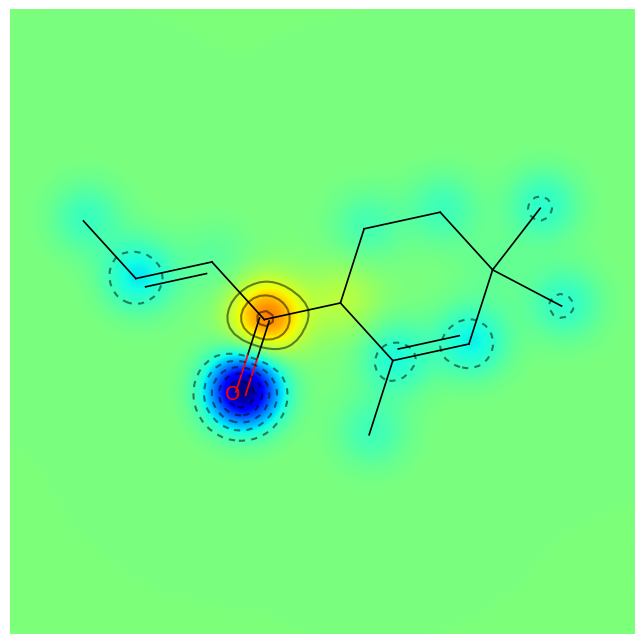

In [ ]:
mol = Chem.MolFromSmiles(df["SMILES"][0])
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
print(f"FOR THE SMILES: {df['SMILES'][0]}\n")

Crippen contributions to logP.

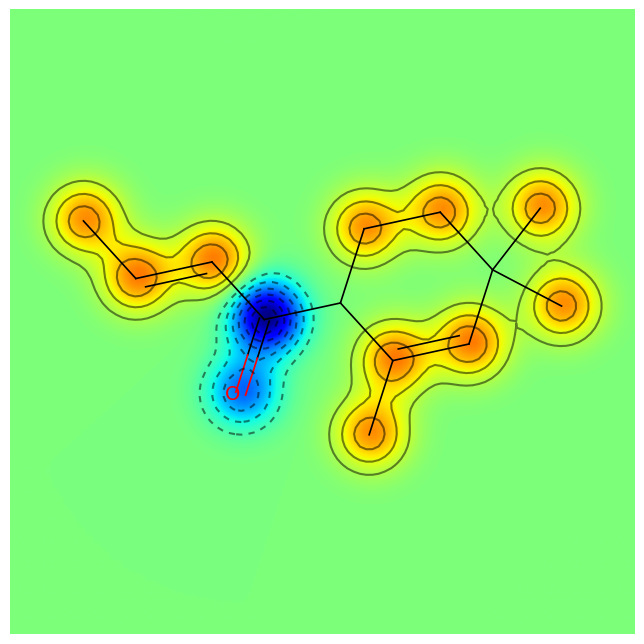

In [ ]:



contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='jet', contourLines=10)

## FINGERPRINTS

Function to Load Fingerprints

In [ ]:
# def add_selected_fingerprints(df, smiles_col='SMILES', rdkit_fp=False, atompair_fp=False, torsion_fp=False, maccs_fp=False, morgan_fp=False):
#     df['Mol'] = df[smiles_col].apply(Chem.MolFromSmiles)

#     if rdkit_fp:
#         rdkit_fps = df['Mol'].apply(lambda mol: list(RDKFingerprint(mol)) if mol else [None]*2048)
#         rdkit_df = pd.DataFrame(rdkit_fps.tolist(), columns=[f'RDKit_FP_{i}' for i in range(2048)])
#         df = pd.concat([df, rdkit_df], axis=1)

#     if atompair_fp:
#         atompair_fps = df['Mol'].apply(lambda mol: list(rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol)) if mol else [None]*2048)
#         atompair_df = pd.DataFrame(atompair_fps.tolist(), columns=[f'AtomPair_FP_{i}' for i in range(2048)])
#         df = pd.concat([df, atompair_df], axis=1)

#     if torsion_fp:
#         torsion_fps = df['Mol'].apply(lambda mol: list(rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)) if mol else [None]*2048)
#         torsion_df = pd.DataFrame(torsion_fps.tolist(), columns=[f'TopologicalTorsion_FP_{i}' for i in range(2048)])
#         df = pd.concat([df, torsion_df], axis=1)

#     if maccs_fp:
#         maccs_fps = df['Mol'].apply(lambda mol: list(MACCSkeys.GenMACCSKeys(mol)) if mol else [None]*166)
#         maccs_df = pd.DataFrame(maccs_fps.tolist(), columns=[f'MACCS_FP_{i}' for i in range(166)])
#         df = pd.concat([df, maccs_df], axis=1)

#     if morgan_fp:
#         morgan_fps = df['Mol'].apply(lambda mol: list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)) if mol else [None]*2048)
#         morgan_df = pd.DataFrame(morgan_fps.tolist(), columns=[f'Morgan_FP_{i}' for i in range(2048)])
#         df = pd.concat([df, morgan_df], axis=1)

#     df = df.drop(columns=['Mol'])

#     return df


# # Add selected fingerprints to DataFrame (choose which ones to compute)
# df_fingerprints = add_selected_fingerprints(df
#                               #  ,rdkit_fp=True
#                               #  ,atompair_fp=True
#                               #  ,torsion_fp=True
#                               #  ,maccs_fp=True
#                                ,morgan_fp=True
#                                )
# df_fingerprints

In [ ]:
# df_fingerprints.to_csv(dataset_path+'smiles_morgan_fp.csv', index=False)